# Calculating Thermodynamics Observables with a quantum computer

In [1]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial

from qiskit.utils import QuantumInstance
from qiskit import Aer
from qiskit.algorithms import NumPyMinimumEigensolver, VQE

from qiskit_nature.drivers import PySCFDriver, UnitsType, Molecule
from qiskit_nature.problems.second_quantization.electronic.electronic_structure_problem import ElectronicStructureProblem
from qiskit_nature.operators.second_quantization.qubit_converter import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
from qiskit_nature.algorithms.pes_samplers import BOPESSampler
import qiskit_nature.constants as const
from qiskit_nature.algorithms.pes_samplers.potentials.energy_surface_spline import EnergySurface1DSpline
from thermodynamics_utils.thermodynamics import constant_volume_heat_capacity
from thermodynamics_utils.vibronic_structure_fd import VibrationalStructure1DFD
from thermodynamics_utils.partition_function import DiatomicPartitionFunction
from thermodynamics_utils.thermodynamics import Thermodynamics

import warnings
warnings.simplefilter('ignore', np.RankWarning)

/Users/bpa/qiskit/qiskit-terra/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  "future release.", DeprecationWarning)
/Users/bpa/opt/anaconda3/envs/test/lib/python3.6/site-packages/qiskit/aqua/operators/operator_globals.py:48: DeprecationWarning: `from_label` is deprecated and will be removed no earlier than 3 months after the release date. Use Pauli(label) instead.
  X = make_immutable(PrimitiveOp(Pauli.from_label('X')))


A preliminary draft with more information related to this tutorial can be foung in preprint: Stober et al, arXiv 2003.02303 (2020)

### Calculation of the Born Openheimer Potenitial Energy Surface (BOPES) 

To compute thermodynamic observables we begin with single point energy calculation which calculates the wavefunction and charge density and therefore  the energy of a particular arrangement of nuclei. Here we  compute the Born-Oppenheimer potential energy surface of a hydrogen molecule, as an example, which is simply the electronic energy as a function of bond length. 

In [2]:
qubit_converter = QubitConverter(JordanWignerMapper())
quantum_instance = QuantumInstance(backend=Aer.get_backend('statevector_simulator'))
solver = VQE(quantum_instance=quantum_instance)

me_gss = GroundStateEigensolver(qubit_converter, solver)

In [3]:
stretch1 = partial(Molecule.absolute_distance, atom_pair=(1, 0))
mol = Molecule(geometry=[('H', [0., 0., 0.]),
                        ('H', [0., 0., 0.2])],
                       degrees_of_freedom=[stretch1],
                       masses=[1.6735328E-27, 1.6735328E-27]
                       )


# pass molecule to PSYCF driver
driver = PySCFDriver(molecule=mol)

es_problem = ElectronicStructureProblem(driver)

In [4]:
# BOPES sampler testing
bs = BOPESSampler(gss=me_gss, 
                  bootstrap=True)
points = np.linspace(0.45, 5, 50)
res = bs.sample(es_problem,points)

In [5]:
energies = []
bs_res_full = res.raw_results
for point in points:
    energy = bs_res_full[point].computed_energies + bs_res_full[point].nuclear_repulsion_energy
    energies.append(energy)

Text(0, 0.5, 'Energy')

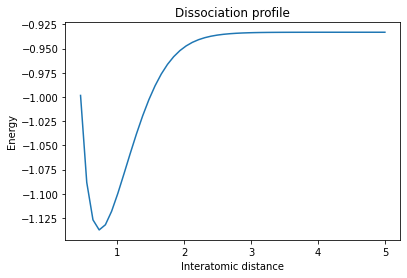

In [6]:
fig = plt.figure()
plt.plot(points,energies)
plt.title('Dissociation profile')
plt.xlabel('Interatomic distance')
plt.ylabel('Energy')

In [7]:
energy_surface = EnergySurface1DSpline()

xdata = res.points
ydata = res.energies
energy_surface.fit(xdata=xdata, ydata=ydata)

(-1.1576822288696493, -0.9127518285151978)

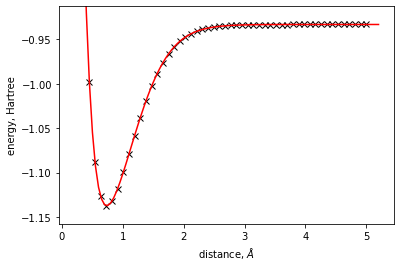

In [8]:
plt.plot(xdata, ydata, 'kx')
x = np.arange(min(xdata) - 0.25, max(xdata) + 0.25, 0.05)
plt.plot(x, energy_surface.eval(x), 'r-')
plt.xlabel(r'distance, $\AA$')
plt.ylabel('energy, Hartree')
dist = max(ydata) - min(ydata)
plt.ylim(min(ydata) - 0.1 * dist, max(ydata) + 0.1 * dist)

### Calculation of the molecular Vibrational Energy levels

The Born-Oppeheimer approximation removes internuclear vibrations from the molecular Hamiltonian and the energy computed from quantum mechanical ground-state energy calculations using this approximation contain only the electronic energy. Since even at absolute zero internuclear vibrations still occur, a correction is required to obtain the true zero-temperature energy of a molecule. This correction is called the zero-point vibrational energy (ZPE), which is computed by summing the contribution from internuclear vibrational modes. Therefore, the next step in computing thermodynamic observables is determining the vibrational energy levels. This can be done by constructing the Hessian matrix based on computed single point energies close to the equilibrium bond length. The eigenvalues of the Hessian matrix can then be used to determine the vibrational energy levels and the zero-point vibrational energy 	
\begin{equation}
{\rm ZPE} = \frac{1}{2}\, \sum_i ^M \nu_i \, ,
\end{equation}
with $\nu_i$ being the vibrational frequencies, $M = 3N − 6$ or $M = 3N − 5$ for non-linear or linear molecules, respectively, and $N$ is number of the particles.  

Here we fit a "full" energy surface using a 1D spline potential and use it to evaluate molecular vibrational energy levels.


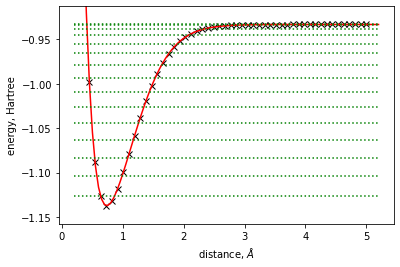

In [9]:
vibrational_structure = VibrationalStructure1DFD(mol, energy_surface)

plt.plot(xdata, ydata, 'kx')
x = np.arange(min(xdata) - 0.25, max(xdata) + 0.25, 0.05)
plt.plot(x, energy_surface.eval(x), 'r-')
plt.xlabel(r'distance, $\AA$')
plt.ylabel('energy, Hartree')
dist = max(ydata) - min(ydata)
plt.ylim(min(ydata) - 0.1 * dist, max(ydata) + 0.1 * dist)
for N in range(15):
    on = np.ones(x.shape)
    on *= (energy_surface.eval(energy_surface.get_equilibrium_geometry()) +
           vibrational_structure.vibrational_energy_level(N))
    plt.plot(x, on, 'g:')
on = np.ones(x.shape)

plt.show()


### Create a partition function for the calculation of heat capacity


The partition function for a molecule is the product of contributions from translational, rotational, vibrational, electronic, and nuclear degrees of freedom. Having the vibrational frequencies, now we can obtain the vibrational partition function  $q_{\rm vibration}$ to compute the whole molecular partition function 
\begin{equation}
q_{\rm vibration} = \prod_{i=1} ^M \frac{\exp\,(-\Theta_{\nu_i}/2T)}{1-\exp\,(-\Theta_{\nu_i}/2T} \, . 
\end{equation} 
Here $\Theta_{\nu_i}= h\nu_i/k_B$, $T$ is the temperature and $k_B$ is the Boltzmann constant.  

The single-point energy calculations and the resulting partition function can be used to calculate the (constant volume or constant pressure) heat capacity of the molecules. The constant volume heat capacity, for example, is given by 

\begin{equation}
C_v = \left.\frac{\partial U}{\partial T}\right|_{N,V}\, ,
\qquad
{\rm with} \quad
U=k_B T^2 \left.\frac{\partial {\rm ln} Q}{\partial T}\right|_{N,V} .
\end{equation}

$U$ is the internal energy, $V$ is the volume and $Q$ is the partition function. 



Here we illustrate the simplest usage of the partition function, namely creating a Thermodynamics object to compute properties like the constant pressure heat capacity defined above. 

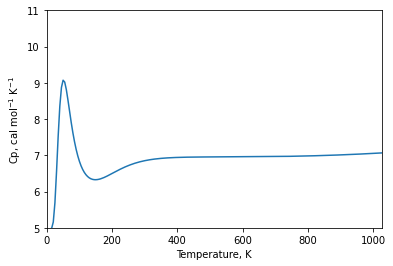

In [10]:
Q = DiatomicPartitionFunction(mol, energy_surface, vibrational_structure)

P = 101350  # Pa
temps = np.arange(10, 1050, 5)  # K

mol.spins = [1/2,1/2]

td = Thermodynamics(Q, pressure = 101350)
td.set_pressure(101350)
temps = np.arange(10, 1500, 5)
ymin = 5
ymax = 11

plt.plot(temps,
         td.constant_pressure_heat_capacity(temps) / const.CAL_TO_J)
plt.xlim(0, 1025)
plt.ylim(ymin, ymax)
plt.xlabel('Temperature, K')
plt.ylabel('Cp, cal mol$^{-1}$ K$^{-1}$')

plt.show()

Here we demonstrate how to access particular components (the rotational part) of the partition function, which in the H2 case we can further split to para-hydrogen and ortho-hydrogen   components.

In [11]:
eq = Q.get_partition(part="rot", split="eq")
para = Q.get_partition(part="rot", split="para")
ortho = Q.get_partition(part="rot", split="ortho")

We will now plot the constant volume heat capacity (of the rotational part) demonstrating how we can call directly the functions in the 'thermodynamics' module, providing a callable object for the partition function (or in this case its rotational component). Note that in the plot we normalize the plot dividing by the universal gas constant R (Avogadro's number times Boltzman's constant) and we use crossed to compare with experimental data found in literature.

In [12]:
# REFERENCE DATA from literature
df_brink_T = [80.913535,135.240157,176.633783,219.808499,246.226899]
df_brink_Cv = [0.118605,0.469925,0.711510,0.833597,0.895701]

df_eucken_T = [25.120525, 30.162485, 36.048121, 41.920364, 56.195875, 62.484934, 72.148692, 73.805910, 73.804236, 92.214423,180.031917,230.300866]
df_eucken_Cv  = [0.012287,0.012354,0.008448,0.020478,0.032620,0.048640,0.048768,0.076678,0.078670,0.170548,0.667731,0.847681]

df_gia_T = [190.919338,195.951254,202.652107,204.292585,209.322828,225.300754,234.514217,243.747768]
df_gia_Cv = [0.711700,0.723719,0.749704,0.797535,0.811546,0.797814,0.833793,0.845868]

df_parting_T = [80.101665, 86.358919,185.914204,239.927797]
df_parting_Cv = [0.084730,0.138598,0.667809,0.891634]

df_ce_T = [80.669344,135.550569,145.464190,165.301153,182.144856,203.372528,237.993108,268.696642,294.095771,308.872014]
df_ce_Cv = [0.103048,0.467344,0.541364,0.647315,0.714078,0.798258,0.891147,0.944848,0.966618,0.985486]

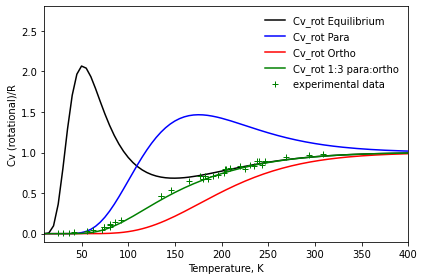

In [13]:
HeatCapacity = constant_volume_heat_capacity

R = const.N_A * const.KB_J_PER_K
plt.plot(temps,
         HeatCapacity(eq, temps) / R, '-k',
         label='Cv_rot Equilibrium')
plt.plot(temps, HeatCapacity(para, temps) / R, '-b',
         label='Cv_rot Para')
plt.plot(temps, HeatCapacity(ortho, temps) / R, '-r',
         label='Cv_rot Ortho')
plt.plot(temps, 0.25 * HeatCapacity(para, temps) / R
         + 0.75 * HeatCapacity(ortho, temps) / R, '-g',
         label='Cv_rot 1:3 para:ortho')
plt.plot(df_brink_T, df_brink_Cv, '+g')
plt.plot(df_eucken_T, df_eucken_Cv, '+g')
plt.plot(df_gia_T, df_gia_Cv, '+g')
plt.plot(df_parting_T, df_parting_Cv, '+g')
plt.plot(df_ce_T, df_ce_Cv, '+g', label = 'experimental data')
plt.legend(loc='upper right', framealpha=100, frameon=False)
plt.xlim(10, 400)
plt.ylim(-0.1, 2.8)
plt.xlabel('Temperature, K')
plt.ylabel('Cv (rotational)/R')
plt.tight_layout()
plt.show()


In [14]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright